# The Battle of Neighborhoods

### *Import necessary Libraries*

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

### *Data Collection, Cleaning and Processing*

#### The rental data of Bangalore is collected from www.makaan.com website. The complete dataset is available in 85 webpages. Data scraping from these multiple webpages is done using BeautifulSoup.

In [2]:
# Run the 1st webpage through BeautifulSoup and check the structure of the webpage.

source = requests.get('https://www.makaan.com/price-trends/property-rates-for-rent-in-bangalore').text
soup = BeautifulSoup(source, 'html.parser')
# print(soup.prettify())

In [3]:
# Extracting the rental data from the 1st webpage and transforming it into a Pandas Dataframe.

rent_table = soup.find("table", attrs={"class": "tbl"})
    
rent_data = [[cell.text for cell in row.find_all(["th","td"])]
                        for row in rent_table.find_all("tr")]

df_rent = pd.DataFrame(rent_data)

In [4]:
# Run a loop to extract the data from rest of the applicable webpages and append the data to "df_rent".

for page in range(2,86):
    source1 = requests.get('https://www.makaan.com/price-trends/property-rates-for-rent-in-bangalore?page='+str(page)).text
    soup1 = BeautifulSoup(source1, 'html.parser')
    rent_table1 = soup1.find("table", attrs={"class": "tbl"})
    
    rent_data1 = [[cell.text for cell in row.find_all(["th","td"])]
                        for row in rent_table1.find_all("tr")]

    df_rent1 = pd.DataFrame(rent_data1)
    df_rent=df_rent.append(df_rent1,ignore_index=True)

df_rent.head()

,0,1,2,3,4,5,6
0,Locality Name,Rental Rates,None,None,None,None,None
1,"{""city"":""Bangalore"",""typeAheadType"":""locality""...",1 BHk,2 BHK,3 BHK,None,None,None
2,Rent range,Avg rent,Rent range,Avg rent,Rent range,Avg rent,None
3,HSR Layout,"5,750 - 40,000","17,662.94","17,000 - 50,000","26,700","32,000 - 1.2 L","58,46.51"
4,Koramangala,"7,000 - 45,000","17,144.21","14,000 - 60,000","29,525.64","23,000 - 1.2 L","53,621.62"


In [5]:
# Assign meaningful column names.

df_rent.columns=['Locality','1BHK_Rent_Range','1BHK_Avg_Rent','2BHK_Rent_Range','2BHK_Avg_Rent','3BHK_Rent_Range','3BHK_Avg_Rent']
df_rent.head()

,Locality,1BHK_Rent_Range,1BHK_Avg_Rent,2BHK_Rent_Range,2BHK_Avg_Rent,3BHK_Rent_Range,3BHK_Avg_Rent
0,Locality Name,Rental Rates,None,None,None,None,None
1,"{""city"":""Bangalore"",""typeAheadType"":""locality""...",1 BHk,2 BHK,3 BHK,None,None,None
2,Rent range,Avg rent,Rent range,Avg rent,Rent range,Avg rent,None
3,HSR Layout,"5,750 - 40,000","17,662.94","17,000 - 50,000","26,700","32,000 - 1.2 L","58,46.51"
4,Koramangala,"7,000 - 45,000","17,144.21","14,000 - 60,000","29,525.64","23,000 - 1.2 L","53,621.62"


In [6]:
# Drop the rows which do not have the locality or rental rates data (For example: The 1st 3 rows in df_rent dataframe).
df_rent.drop(df_rent[(df_rent['1BHK_Rent_Range']=='Rental Rates')|(df_rent['1BHK_Rent_Range']=='1 BHk')|(df_rent['1BHK_Rent_Range']=='Avg rent')].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)

# Drop the columns which have the rental rate range values. We will use only the average rental rates.
df_rent.drop(['1BHK_Rent_Range','2BHK_Rent_Range','3BHK_Rent_Range'],axis=1,inplace=True)

# Drop the rows which do not have data in any of the 1BHK, 2BHK or 3BHK columns.
df_rent.drop(df_rent[(df_rent['1BHK_Avg_Rent']=='-')|(df_rent['2BHK_Avg_Rent']=='-')|(df_rent['3BHK_Avg_Rent']=='-')].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)

# Drop rows for duplicate locality name 
df_rent.drop(df_rent[(df_rent['Locality']=='Electronic City Phase II')|(df_rent['Locality']=='Indiranagar')|(df_rent['Locality']=='Indiranagar HAL 2nd Stage')|(df_rent['Locality']=='kengeri satellite town')|(df_rent['Locality']=='Yeshwantpur')].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)

# Drop rows where rental data do not appear to be in accordance with other rows.
df_rent.drop(df_rent[(df_rent['Locality']=='HSR Layout')|(df_rent['Locality']=='Bellandur')|(df_rent['Locality']=='Murugeshpalya')|(df_rent['Locality']=='Thanisandra')|(df_rent['Locality']=='Subramanyapura')|(df_rent['Locality']=='Kadugodi')|(df_rent['Locality']=='Kasturi Nagar')|(df_rent['Locality']=='J. P. Nagar')|(df_rent['Locality']=='Yemalur')|(df_rent['Locality']=='Doddanekundi')|(df_rent['Locality']=='NRI Layout')].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)


df_rent.head()

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent
0,Koramangala,"17,144.21","29,525.64","53,621.62"
1,Whitefield,"13,416.07","18,346.65","37,33.33"
2,Krishnarajapura,"13,212.5","15,176.47","60,500"
3,Begur,"9,600","14,681.25","22,100"
4,Varthur,"8,787","14,400","74,000"


In [7]:
# Get the latitude and longitude data of the localities using GeoPy package (Nominatim API)

geolocator = Nominatim(user_agent="bangalore_explorer")

df_rent['Latitude'] = df_rent['Locality'].apply(lambda x: geolocator.geocode(x).latitude if geolocator.geocode(x) != None else 'NF')
df_rent['Longitude'] = df_rent['Locality'].apply(lambda x: geolocator.geocode(x).longitude if geolocator.geocode(x) != None else 'NF')
df_rent

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude
0,Koramangala,"17,144.21","29,525.64","53,621.62",13.2924,77.7519
1,Whitefield,"13,416.07","18,346.65","37,33.33",44.3731,-71.6119
2,Krishnarajapura,"13,212.5","15,176.47","60,500",12.0325,76.8056
3,Begur,"9,600","14,681.25","22,100",41.9542,3.20883
4,Varthur,"8,787","14,400","74,000",12.9406,77.747
5,Devanahalli,"18,000","15,285.71","22,000",13.2484,77.7134
6,Chandapura,"9,120","11,466.67","16,000",17.4436,77.4334
7,Mahadevapura,"11,205.26","17,521.43","35,000",12.9935,77.6924
8,Whitefield Hope Farm Junction,"9,250","16,000","36,580.77",12.9829,77.7533
9,Budigere Cross,"22,000","19,000","19,500",13.0464,77.7503


In [8]:
# Drop the rows for which latitude and longitude data are not available.
df_rent.drop(df_rent[(df_rent['Latitude']=='NF')|(df_rent['Longitude']=='NF')].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)

df_rent.shape

(187, 6)

In [9]:
# Drop any outliers.
df_rent.drop(df_rent[(df_rent['Latitude']<12.80)|(df_rent['Latitude']>13.11)|(df_rent['Longitude']<77.48)|(df_rent['Longitude']>77.78)].index,inplace=True)
df_rent.reset_index(drop=True,inplace=True)

df_rent.shape

(110, 6)

In [10]:
df_rent.head()

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude
0,Varthur,"8,787","14,400","74,000",12.9406,77.747
1,Mahadevapura,"11,205.26","17,521.43","35,000",12.9935,77.6924
2,Whitefield Hope Farm Junction,"9,250","16,000","36,580.77",12.9829,77.7533
3,Budigere Cross,"22,000","19,000","19,500",13.0464,77.7503
4,Jakkur,"12,666.67","16,475","43,000",13.0785,77.6069


In [11]:
# I was unable to convert all the rental values from string to float. 
# So, copied the df_rent data to an excel, updated the types and imported the excel in IBM Watson Studio and imported it as a dataframe for this project.

In [12]:
# The code was removed by Watson Studio for sharing.

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude
0,1st Phase JP Nagar,7500.00,16500.00,42000.00,12.9119,77.5799
1,2nd Phase JP Nagar,16500.00,25250.00,32000.00,12.9117,77.5918
2,3rd Block HBR Layout,15000.00,24000.00,30000.00,13.0359,77.6324
3,5th Phase,11916.67,13583.33,28333.33,13.1051,77.5715
4,Adugodi,8500.00,35450.00,44000.00,12.9428,77.6104


### *Bangalore map creation with localities superimposed on top.*

In [13]:
# Get geographical coordinates of Bangalore.
address = 'Bangalore'

geolocator = Nominatim(user_agent="bangalore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


In [14]:
# Create map of Bangalore using latitude and longitude values
map_bnglr = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to map
for lat, lng, locality in zip(df_data['Latitude'], df_data['Longitude'], df_data['Locality']):
    label = folium.Popup(locality, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bnglr)  
    
map_bnglr

### *Plot charts of localities based on rental rates*

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt

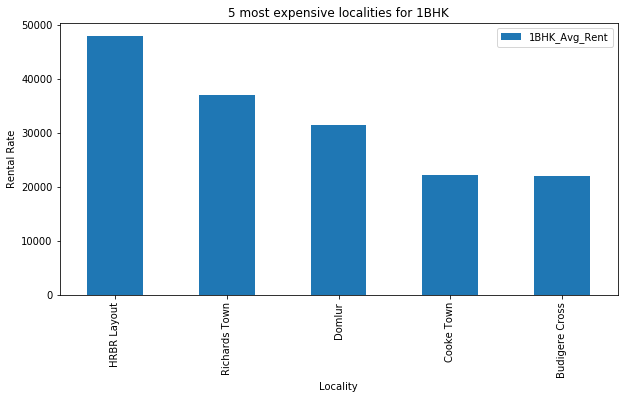

In [16]:
df_1BHK_High=df_data.nlargest(5,'1BHK_Avg_Rent')

df_1BHK_High.plot(x='Locality',y='1BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 most expensive localities for 1BHK') # add title to the plot

plt.show()

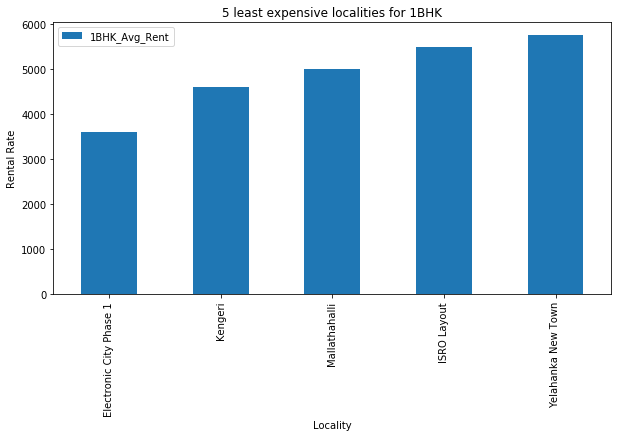

In [17]:
df_1BHK_Low=df_data.nsmallest(5,'1BHK_Avg_Rent')

df_1BHK_Low.plot(x='Locality',y='1BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 least expensive localities for 1BHK') # add title to the plot

plt.show()

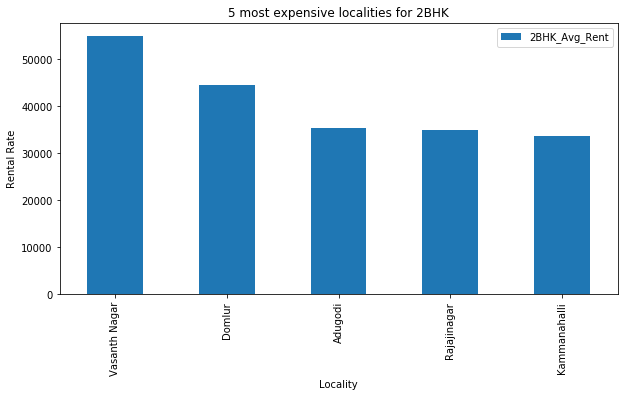

In [18]:
df_2BHK_High=df_data.nlargest(5,'2BHK_Avg_Rent')

df_2BHK_High.plot(x='Locality',y='2BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 most expensive localities for 2BHK') # add title to the plot

plt.show()

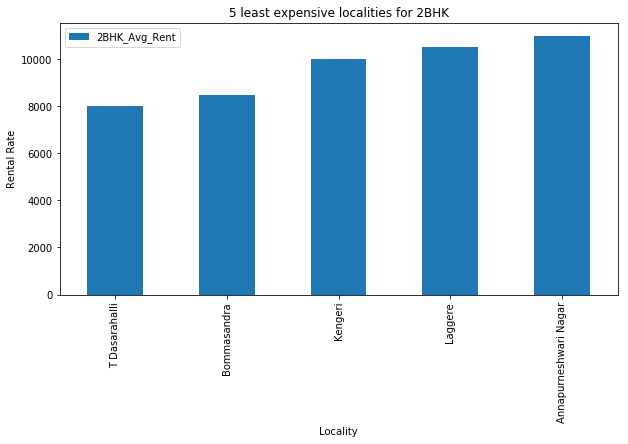

In [19]:
df_2BHK_Low=df_data.nsmallest(5,'2BHK_Avg_Rent')

df_2BHK_Low.plot(x='Locality',y='2BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 least expensive localities for 2BHK') # add title to the plot

plt.show()

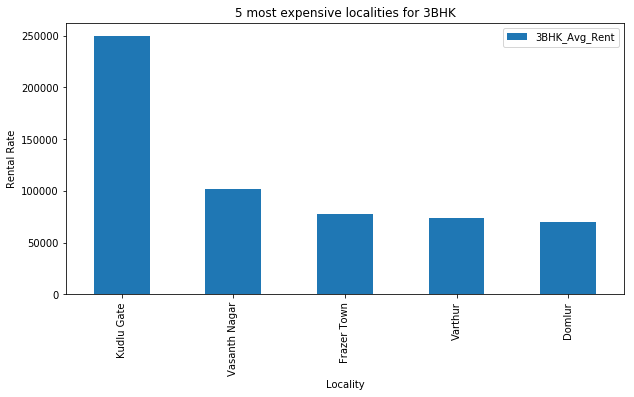

In [20]:
df_3BHK_High=df_data.nlargest(5,'3BHK_Avg_Rent')

df_3BHK_High.plot(x='Locality',y='3BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 most expensive localities for 3BHK') # add title to the plot

plt.show()

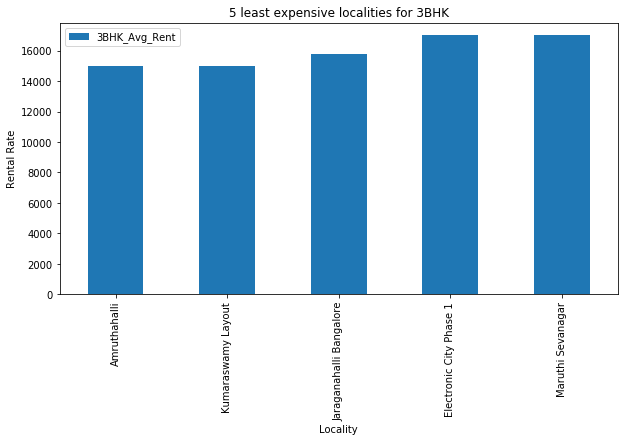

In [21]:
df_3BHK_Low=df_data.nsmallest(5,'3BHK_Avg_Rent')

df_3BHK_Low.plot(x='Locality',y='3BHK_Avg_Rent',kind='bar', figsize=(10, 5))

plt.xlabel('Locality') # add to x-label to the plot
plt.ylabel('Rental Rate') # add y-label to the plot
plt.title('5 least expensive localities for 3BHK') # add title to the plot

plt.show()

### *Clustering Localities based on Rental rates*

In [22]:
# Remove the Locality and their coordinates

df_rent_cluster=df_data.drop(['Locality','Latitude','Longitude'],axis=1)
df_rent_cluster.head()

,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent
0,7500.00,16500.00,42000.00
1,16500.00,25250.00,32000.00
2,15000.00,24000.00,30000.00
3,11916.67,13583.33,28333.33
4,8500.00,35450.00,44000.00


In [23]:
# Normalize the dataset

from sklearn.preprocessing import StandardScaler

X = df_rent_cluster.values[:,:]
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-7.82736644e-01, -4.49529765e-01,  2.43334902e-01],
       [ 7.58325013e-01,  8.56898663e-01, -1.50637959e-01],
       [ 5.01481404e-01,  6.70266030e-01, -2.29432531e-01],
       [-2.64743341e-02, -8.85006406e-01, -2.95094806e-01],
       [-6.11507571e-01,  2.37982094e+00,  3.22129474e-01],
       [ 1.07224441e+00,  1.47694659e-01, -8.20391823e-01],
       [ 5.01481404e-01, -1.27071335e+00, -5.44610820e-01],
       [-7.82505812e-02,  1.33191634e-02, -4.52683950e-01],
       [ 3.53082303e-01,  3.71653818e-01, -4.26418962e-01],
       [ 5.58557191e-01,  2.97000765e-01, -1.50637959e-01],
       [ 7.43104461e-01,  3.98372146e-01, -2.10828345e-01],
       [-8.16982459e-01,  7.30416058e-02, -1.50637959e-01],
       [-4.92869796e-01, -4.49529765e-01, -4.26418962e-01],
       [-7.82736644e-01, -1.64397861e+00, -4.26418962e-01],
       [-7.82736644e-01, -3.00223659e-01, -2.29432531e-01],
       [-2.69049425e-01, -5.24182819e-01, -3.87021675e-01],
       [ 1.24777443e-01, -2.44233870e-01

In [24]:
# Grouping data into 5 clusters
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 3 0 1 1 1 0 1 1 1 0 1
 1 0 0 1 1 1 0 1 3 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 2 1 1 1 1 0 1 1 0
 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 3 1 1 0 1 1 0 1 1 1 0 0 1 4 0 1 0 1 1 1 0]


In [25]:
df_rent_cluster["Labels"] = labels
df_rent_cluster.head(5)

,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Labels
0,7500.00,16500.00,42000.00,1
1,16500.00,25250.00,32000.00,0
2,15000.00,24000.00,30000.00,0
3,11916.67,13583.33,28333.33,1
4,8500.00,35450.00,44000.00,0


In [26]:
# Check the centroid values by averaging the features in each cluster

df_rent_cluster.groupby('Labels').mean()

,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent
Labels,,,
0,13927.763636,23399.498864,37503.628409
1,9507.346885,15580.538361,28908.723770
2,8571.430000,20625.000000,250000.000000
3,38833.333333,30190.476667,58444.443333
4,10000.000000,55000.000000,101666.670000


In [27]:
# Add the cluser labels to df_data

df_data["Labels"] = labels
df_data.head()

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude,Labels
0,1st Phase JP Nagar,7500.00,16500.00,42000.00,12.9119,77.5799,1
1,2nd Phase JP Nagar,16500.00,25250.00,32000.00,12.9117,77.5918,0
2,3rd Block HBR Layout,15000.00,24000.00,30000.00,13.0359,77.6324,0
3,5th Phase,11916.67,13583.33,28333.33,13.1051,77.5715,1
4,Adugodi,8500.00,35450.00,44000.00,12.9428,77.6104,0


#### Visualize the clusters

In [28]:
# create map
map_rent_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_data['Latitude'], df_data['Longitude'], df_data['Locality'], df_data['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_rent_clusters)
       
map_rent_clusters

#### Examine Clusters

In [49]:
# Cluster 1
df_data.loc[df_data['Labels'] == 0, df_data.columns[list(range(0, df_data.shape[1]))]]

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude,Labels
1,2nd Phase JP Nagar,16500.00,25250.00,32000.00,12.9117,77.5918,0
2,3rd Block HBR Layout,15000.00,24000.00,30000.00,13.0359,77.6324,0
4,Adugodi,8500.00,35450.00,44000.00,12.9428,77.6104,0
5,Amruthahalli,18333.33,20500.00,15000.00,13.0665,77.5966,0
8,Ashwini Layout,14133.33,22000.00,25000.00,12.9389,77.6286,0
9,Banashankari Stage 2nd,15333.33,21500.00,32000.00,12.9246,77.5646,0
10,Banaswadi,16411.11,22178.95,30472.22,13.0142,77.6519,0
16,BTM Layout,12800.00,17875.00,54000.00,12.9152,77.6103,0
18,Budigere Cross,22000.00,19000.00,19500.00,13.0464,77.7503,0
19,byatarayanapura,14166.67,22500.00,42500.00,13.0621,77.5964,0


In [50]:
# Cluster 2
df_data.loc[df_data['Labels'] == 1, df_data.columns[list(range(0, df_data.shape[1]))]]

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude,Labels
0,1st Phase JP Nagar,7500.00,16500.00,42000.00,12.9119,77.5799,1
3,5th Phase,11916.67,13583.33,28333.33,13.1051,77.5715,1
6,Annapurneshwari Nagar,15000.00,11000.00,22000.00,12.9742,77.5880,1
7,Arakere,11614.29,19600.00,24333.33,12.8785,77.6042,1
11,Bilekahalli,7300.00,20000.00,32000.00,12.8996,77.6103,1
12,Bommanahalli,9192.86,16500.00,25000.00,12.9089,77.6239,1
13,Bommasandra,7500.00,8500.00,25000.00,12.8162,77.6916,1
14,BTM 1st Stage,7500.00,17500.00,30000.00,12.9190,77.6113,1
15,BTM 2nd Stage,10500.00,16000.00,26000.00,12.9141,77.6189,1
17,BTM Layout 2nd Stage,12416.67,16000.00,30000.00,12.9140,77.6079,1


In [51]:
# Cluster 3
df_data.loc[df_data['Labels'] == 2, df_data.columns[list(range(0, df_data.shape[1]))]]

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude,Labels
65,Kudlu Gate,8571.43,20625.0,250000.0,12.8899,77.6397,2


In [52]:
# Cluster 4
df_data.loc[df_data['Labels'] == 3, df_data.columns[list(range(0, df_data.shape[1]))]]

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude,Labels
26,Domlur,31500.0,44571.43,70000.00,12.9625,77.6382,3
45,HRBR Layout,48000.0,24000.00,40000.00,13.0252,77.6340,3
89,Richards Town,37000.0,22000.00,65333.33,13.0042,77.6158,3


In [53]:
# Cluster 5
df_data.loc[df_data['Labels'] == 4, df_data.columns[list(range(0, df_data.shape[1]))]]

,Locality,1BHK_Avg_Rent,2BHK_Avg_Rent,3BHK_Avg_Rent,Latitude,Longitude,Labels
102,Vasanth Nagar,10000.0,55000.0,101666.67,12.9887,77.5852,4


### *Explore the Localities using Foursquare API*

#### Define Foursquare Credentials and Version

In [29]:
# The code was removed by Watson Studio for sharing.

#### Create a dataframe containing only locality, latitude and longitude data.

In [30]:
# Drop the columns which have the rental rate values.
df_bnglr=df_rent.drop(['1BHK_Avg_Rent','2BHK_Avg_Rent','3BHK_Avg_Rent'],axis=1)
df_bnglr.head()
#df_bnglr.shape

,Locality,Latitude,Longitude
0,Varthur,12.9406,77.747
1,Mahadevapura,12.9935,77.6924
2,Whitefield Hope Farm Junction,12.9829,77.7533
3,Budigere Cross,13.0464,77.7503
4,Jakkur,13.0785,77.6069


In [31]:
## create a function to get the venues for all the Locality in Bangalore

def getNearbyVenues(names, latitudes, longitudes, radius=1000,LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Locality', 
                  'Locality Latitude', 
                  'Locality Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
# find the venues in all Bangalore Locality
bnglr_venues = getNearbyVenues(names=df_bnglr['Locality'],
                                   latitudes=df_bnglr['Latitude'],
                                   longitudes=df_bnglr['Longitude']
                                  )

Varthur
Mahadevapura
Whitefield Hope Farm Junction
Budigere Cross
Jakkur
Marathahalli
Yelahanka
Indira Nagar
Horamavu
BTM Layout
Electronic City Phase 1
Kalyan Nagar
Electronic City Phase 2
Harlur
Banaswadi
Hebbal
Sarjapur
Nagarbhavi
Ramamurthy Nagar
Rajajinagar
Bommanahalli
Bommasandra
Gottigere
Hulimavu
Kengeri
Konanakunte
Ejipura
hebbal kempapura
New Thippasandra
Kaggadasapura
Kumaraswamy Layout
Hennur Main Road
Hennur
Ulsoor
Bilekahalli
Kammanahalli
Hosa Road
BTM Layout 2nd Stage
Domlur Layout
Kudlu Gate
HBR Layout
Chikkalasandra
Frazer Town
Hoodi
Jogupalya
Lingarajapuram
hongasandra bangalore
Yelahanka New Town
Arakere
Adugodi
Muneshwara Nagar
Annapurneshwari Nagar
Cooke Town
Kadubeesanahalli
5th Phase
Kudlu
Carmelaram
Sanjaynagar
Cox Town
Vasanth Nagar
Kaval Byrasandra
Amruthahalli
Kalena Agrahara
Padmanabhanagar
byatarayanapura
Nandini Layout
Mallathahalli
Yeshwanthpur
Yelachenahalli
Challaghatta
Sampigehalli
Kaikondrahalli
Byrathi
Parappana Agrahara
Domlur
1st Phase JP Nagar
Ho

In [33]:
bnglr_venues.head()

,Locality,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Varthur,12.940615,77.746994,shri guru narasimha hotel,12.940011,77.747787,Indian Restaurant
1,Varthur,12.940615,77.746994,Vinayaka Theatre,12.935616,77.744496,Indie Movie Theater
2,Varthur,12.940615,77.746994,Varthur Lake,12.947361,77.745345,Lake
3,Varthur,12.940615,77.746994,Unique Hypermarket,12.939105,77.739296,Supermarket
4,Varthur,12.940615,77.746994,Ramagondanahalli Bus Stop,12.947888,77.742059,Bus Station


In [34]:
# check how many venues were returned for each neighborhood
bnglr_venues.groupby('Locality').count()

,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Locality,,,,,,
1st Phase JP Nagar,52,52,52,52,52,52
2nd Phase JP Nagar,99,99,99,99,99,99
3rd Block HBR Layout,10,10,10,10,10,10
5th Phase,11,11,11,11,11,11
Adugodi,45,45,45,45,45,45
Amruthahalli,16,16,16,16,16,16
Annapurneshwari Nagar,51,51,51,51,51,51
Arakere,34,34,34,34,34,34
Ashwini Layout,100,100,100,100,100,100


In [35]:
print('There are {} uniques categories.'.format(len(bnglr_venues['Venue Category'].unique())))

There are 210 uniques categories.


#### Analyze each Locality

In [36]:

# one hot encoding
bnglr_onehot = pd.get_dummies(bnglr_venues[['Venue Category']], prefix="", prefix_sep="")

# add Locality column back to dataframe
bnglr_onehot['Locality'] = bnglr_venues['Locality'] 

# move Locality column to the first column
column_list = bnglr_onehot.columns.tolist()
column_number = int(column_list.index('Locality'))
column_list = [column_list[column_number]] + column_list[:column_number] + column_list[column_number+1:]
bnglr_onehot = bnglr_onehot[column_list]

bnglr_onehot.head()

,Locality,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Animal Shelter,Arcade,Art Gallery,Art Museum,...,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio
0,Varthur,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Varthur,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Varthur,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Varthur,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Varthur,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group rows by locality and by taking the mean of the frequency of occurrence of each category

In [37]:
bnglr_grouped = bnglr_onehot.groupby('Locality').mean().reset_index()
bnglr_grouped

,Locality,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Animal Shelter,Arcade,Art Gallery,Art Museum,...,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio
0,1st Phase JP Nagar,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.038462,0.000000,0.019231,0.000000
1,2nd Phase JP Nagar,0.000000,0.000000,0.010101,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.010101,0.000000,0.000000,0.000000
2,3rd Block HBR Layout,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,5th Phase,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,Adugodi,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
5,Amruthahalli,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6,Annapurneshwari Nagar,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.019608,0.000000,...,0.0,0.000000,0.019608,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
7,Arakere,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
8,Ashwini Layout,0.000000,0.000000,0.000000,0.000000,0.010000,0.0,0.010000,0.000000,0.000000,...,0.0,0.010000,0.000000,0.000000,0.000000,0.0,0.030000,0.000000,0.000000,0.010000
9,BTM 1st Stage,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.064516,0.000000,0.000000,0.000000


#### Print each Locality along with the top 5 most common venues

In [38]:

num_top_venues = 5

for hood in bnglr_grouped['Locality']:
    print("----"+hood+"----")
    temp = bnglr_grouped[bnglr_grouped['Locality'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1st Phase JP Nagar----
                           venue  freq
0              Indian Restaurant  0.21
1           Fast Food Restaurant  0.06
2                    Snack Place  0.04
3  Vegetarian / Vegan Restaurant  0.04
4                   Liquor Store  0.04


----2nd Phase JP Nagar----
                  venue  freq
0     Indian Restaurant  0.24
1  Fast Food Restaurant  0.08
2                  Café  0.07
3    Chinese Restaurant  0.05
4           Coffee Shop  0.04


----3rd Block HBR Layout----
           venue  freq
0    Pizza Place   0.2
1           Café   0.2
2           Road   0.1
3    Bus Station   0.1
4  Jewelry Store   0.1


----5th Phase----
               venue  freq
0  Indian Restaurant  0.45
1             Bakery  0.18
2        Snack Place  0.09
3        Bus Station  0.09
4      Grocery Store  0.09


----Adugodi----
               venue  freq
0  Indian Restaurant  0.13
1             Lounge  0.07
2               Café  0.07
3       Dessert Shop  0.07
4          Bookstore  0.04

#### Put the data into a pandas dataframe

In [39]:

# First, write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## create the new dataframe and display the top 10 venues for each Locality.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Locality']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
locality_venues_sorted = pd.DataFrame(columns=columns)
locality_venues_sorted['Locality'] = bnglr_grouped['Locality']

for ind in np.arange(bnglr_grouped.shape[0]):
    locality_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bnglr_grouped.iloc[ind, :], num_top_venues)

locality_venues_sorted

,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1st Phase JP Nagar,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Snack Place,Chinese Restaurant,Liquor Store,Bus Stop,Jewelry Store,Boarding House,Juice Bar
1,2nd Phase JP Nagar,Indian Restaurant,Fast Food Restaurant,Café,Chinese Restaurant,Coffee Shop,Snack Place,Bakery,Pizza Place,Shopping Mall,South Indian Restaurant
2,3rd Block HBR Layout,Café,Pizza Place,Big Box Store,Bus Station,Road,Diner,Jewelry Store,Kids Store,Dry Cleaner,Financial or Legal Service
3,5th Phase,Indian Restaurant,Bakery,Soccer Field,Grocery Store,Bus Station,Snack Place,Cupcake Shop,Dumpling Restaurant,Flea Market,Fish Market
4,Adugodi,Indian Restaurant,Lounge,Dessert Shop,Café,Donut Shop,Coffee Shop,Brewery,Multiplex,Bookstore,Shopping Mall
5,Amruthahalli,Indian Restaurant,Bus Station,Hotel,Chinese Restaurant,Bubble Tea Shop,Fast Food Restaurant,Brewery,Pizza Place,Ice Cream Shop,Dance Studio
6,Annapurneshwari Nagar,Italian Restaurant,Hotel,Indian Restaurant,Lounge,Mexican Restaurant,Electronics Store,Asian Restaurant,Coffee Shop,Park,Concert Hall
7,Arakere,Café,Multiplex,Electronics Store,Ice Cream Shop,South Indian Restaurant,Indian Restaurant,Movie Theater,Shopping Mall,Tea Room,Bowling Alley
8,Ashwini Layout,Indian Restaurant,Café,Pizza Place,Italian Restaurant,Coffee Shop,Pub,Ice Cream Shop,Chinese Restaurant,Gym / Fitness Center,Vegetarian / Vegan Restaurant
9,BTM 1st Stage,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Bakery,Coffee Shop,Fast Food Restaurant,Ice Cream Shop,Snack Place,Sandwich Place,Café


### *Cluster Localities based on Venues*

In [40]:
# set number of clusters
kclusters = 5

bnglr_clustering = bnglr_grouped.drop('Locality', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bnglr_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
kmeans.labels_.shape

(109,)

In [41]:
kmeans.labels_

array([1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 2, 2,
       1, 2, 1, 1, 2, 2, 1, 1, 1, 3, 2, 1, 2, 3, 1, 1, 1, 1, 2, 1, 2, 2,
       1, 2, 1, 1, 2, 2, 1, 1, 3, 1, 1, 2, 3, 1, 3, 2, 1, 1, 2, 1, 2, 2,
       3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 3, 2],
      dtype=int32)

In [42]:
# add clustering labels
locality_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bnglr_merged = df_bnglr

# merge bnglr_grouped with df_bnglr to add latitude/longitude for each neighborhood
bnglr_merged = bnglr_merged.join(locality_venues_sorted.set_index('Locality'), on='Locality',how='inner')

bnglr_merged.head()

,Locality,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Varthur,12.9406,77.747,1,Indian Restaurant,Indie Movie Theater,Lake,Bus Station,Supermarket,Yoga Studio,Dumpling Restaurant,Flea Market,Fish Market,Financial or Legal Service
1,Mahadevapura,12.9935,77.6924,2,Fast Food Restaurant,Coffee Shop,Clothing Store,French Restaurant,Donut Shop,Café,Bowling Alley,Italian Restaurant,Sporting Goods Shop,Lounge
2,Whitefield Hope Farm Junction,12.9829,77.7533,1,Hotel,Breakfast Spot,Chinese Restaurant,Chaat Place,Eastern European Restaurant,Fast Food Restaurant,Men's Store,Indian Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop
3,Budigere Cross,13.0464,77.7503,4,Bus Stop,Yoga Studio,Food & Drink Shop,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store
4,Jakkur,13.0785,77.6069,1,Café,Indian Restaurant,Clothing Store,Animal Shelter,Donut Shop,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market


#### Visualize the clusters

In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bnglr_merged['Latitude'], bnglr_merged['Longitude'], bnglr_merged['Locality'], bnglr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters

In [44]:
# Cluster 1
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 0, bnglr_merged.columns[list(range(0, bnglr_merged.shape[1]))]]

,Locality,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
73,Parappana Agrahara,12.8817,77.6598,0,Gym,Yoga Studio,Donut Shop,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store


In [45]:
# Cluster 2
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 1, bnglr_merged.columns[list(range(0, bnglr_merged.shape[1]))]]

,Locality,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Varthur,12.9406,77.747,1,Indian Restaurant,Indie Movie Theater,Lake,Bus Station,Supermarket,Yoga Studio,Dumpling Restaurant,Flea Market,Fish Market,Financial or Legal Service
2,Whitefield Hope Farm Junction,12.9829,77.7533,1,Hotel,Breakfast Spot,Chinese Restaurant,Chaat Place,Eastern European Restaurant,Fast Food Restaurant,Men's Store,Indian Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop
4,Jakkur,13.0785,77.6069,1,Café,Indian Restaurant,Clothing Store,Animal Shelter,Donut Shop,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market
5,Marathahalli,12.9553,77.6984,1,Indian Restaurant,Vegetarian / Vegan Restaurant,Restaurant,BBQ Joint,Andhra Restaurant,Dessert Shop,Fast Food Restaurant,Breakfast Spot,Lounge,Bus Station
9,BTM Layout,12.9152,77.6103,1,Indian Restaurant,Bakery,Vegetarian / Vegan Restaurant,Coffee Shop,Snack Place,Ice Cream Shop,Park,Chinese Restaurant,Sandwich Place,Café
10,Electronic City Phase 1,12.8497,77.665,1,Indian Restaurant,Food Court,Coffee Shop,Hotel,Ice Cream Shop,Bar,Sandwich Place,Breakfast Spot,Snack Place,French Restaurant
11,Kalyan Nagar,13.0221,77.6403,1,Indian Restaurant,Café,Fast Food Restaurant,BBQ Joint,Korean Restaurant,Ice Cream Shop,South Indian Restaurant,Bistro,Pizza Place,Lounge
12,Electronic City Phase 2,12.8469,77.6769,1,Indian Restaurant,Hyderabadi Restaurant,Toll Plaza,Basketball Court,Bus Stop,Diner,Café,Vegetarian / Vegan Restaurant,Coworking Space,Deli / Bodega
14,Banaswadi,13.0142,77.6519,1,Indian Restaurant,Department Store,Café,Clothing Store,Bakery,Park,Pharmacy,Pizza Place,Music Venue,Bus Station
15,Hebbal,13.0382,77.5919,1,Indian Restaurant,Pharmacy,Garden Center,Coffee Shop,Pizza Place,Motorcycle Shop,Grocery Store,Lake,Farmers Market,Falafel Restaurant


In [46]:
# Cluster 3
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 2, bnglr_merged.columns[list(range(0, bnglr_merged.shape[1]))]]

,Locality,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Mahadevapura,12.9935,77.6924,2,Fast Food Restaurant,Coffee Shop,Clothing Store,French Restaurant,Donut Shop,Café,Bowling Alley,Italian Restaurant,Sporting Goods Shop,Lounge
6,Yelahanka,13.1007,77.5963,2,Café,Multiplex,Smoke Shop,Fast Food Restaurant,Food Truck,Farmers Market,Clothing Store,Cosmetics Shop,Vegetarian / Vegan Restaurant,Ice Cream Shop
7,Indira Nagar,12.9733,77.6405,2,Indian Restaurant,Ice Cream Shop,Pub,Café,Lounge,Bar,Cocktail Bar,Bakery,Chinese Restaurant,Restaurant
8,Horamavu,13.0273,77.6602,2,Badminton Court,Andhra Restaurant,Athletics & Sports,Kerala Restaurant,Yoga Studio,Food,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
23,Hulimavu,12.8773,77.6028,2,Café,Multiplex,Bakery,Indian Restaurant,South Indian Restaurant,Electronics Store,Movie Theater,Ice Cream Shop,Fast Food Restaurant,Italian Restaurant
26,Ejipura,12.9452,77.6269,2,Café,Pizza Place,Indian Restaurant,Gym / Fitness Center,Ice Cream Shop,Clothing Store,Bengali Restaurant,Juice Bar,Seafood Restaurant,Beer Garden
27,hebbal kempapura,13.0521,77.6018,2,Pharmacy,Department Store,Café,Pizza Place,Fast Food Restaurant,Building,Bus Station,Indian Restaurant,Coworking Space,Dry Cleaner
33,Ulsoor,12.9779,77.6247,2,Hotel,Café,Bar,Chinese Restaurant,Asian Restaurant,Department Store,Restaurant,Clothing Store,Athletics & Sports,Thai Restaurant
38,Domlur Layout,12.9644,77.635,2,Indian Restaurant,Café,Pub,Italian Restaurant,Restaurant,Sports Bar,Lounge,Tea Room,Pizza Place,Asian Restaurant
40,HBR Layout,13.0359,77.6324,2,Café,Pizza Place,Big Box Store,Bus Station,Road,Diner,Jewelry Store,Kids Store,Dry Cleaner,Financial or Legal Service


In [47]:
# Cluster 4
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 3, bnglr_merged.columns[list(range(0, bnglr_merged.shape[1]))]]

,Locality,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Harlur,12.892,77.655,3,Department Store,Indian Restaurant,Badminton Court,Yoga Studio,Dry Cleaner,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market
22,Gottigere,12.8565,77.5877,3,Indian Restaurant,Department Store,Pharmacy,Food Truck,Italian Restaurant,Donut Shop,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market
25,Konanakunte,12.8793,77.5698,3,Vegetarian / Vegan Restaurant,Indian Restaurant,Department Store,Bus Station,Yoga Studio,Dry Cleaner,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
46,hongasandra bangalore,12.8975,77.6281,3,Indian Restaurant,Pizza Place,Department Store,Hotel Bar,Clothing Store,Donut Shop,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market
60,Kaval Byrasandra,13.02,77.6093,3,Department Store,Pharmacy,Indian Restaurant,Gourmet Shop,Bakery,Dry Cleaner,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
62,Kalena Agrahara,12.8661,77.5919,3,Indian Restaurant,Pharmacy,Gym / Fitness Center,Italian Restaurant,Department Store,Dive Bar,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market
90,Mangammanapalya,12.8958,77.6457,3,Indian Restaurant,Bus Station,Automotive Shop,Department Store,Badminton Court,Asian Restaurant,Middle Eastern Restaurant,Coffee Shop,Deli / Bodega,Electronics Store
102,Mailasandra,12.9159,77.4932,3,Indian Restaurant,Arcade,Bus Station,Yoga Studio,Dry Cleaner,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market


In [48]:
# Cluster 5
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 4, bnglr_merged.columns[list(range(0, bnglr_merged.shape[1]))]]

,Locality,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Budigere Cross,13.0464,77.7503,4,Bus Stop,Yoga Studio,Food & Drink Shop,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store
